# Support Vector Machines and the UCI Mushroom Data Set
### Kevin Maher
### <span style="color:blue">Vettejeep365@gmail.com</span>

This is a classification problem, we want to correctly classify mushrooms as edible or poisonous.  We especially do not want to classify poisonous mushrooms as edible.

Imports needed for the script.  Uses Python 2.7.13, numpy 1.11.3, pandas 0.19.2, sklearn 0.18.1, matplotlib 2.0.0.

In [40]:
%matplotlib inline

import pandas as pd
import numpy as np
import itertools

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt

Import the data.  Even though the UCI file has a 'txt' extension it is formatted as a 'csv' file.  File header names are not provided in the UCI data file but are available from the UCI website (https://archive.ics.uci.edu/ml/datasets/mushroom). 

In [41]:
columns = ('class', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor',
               'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color',
               'stalk_shape', 'stalk_root', 'stalk_surface_above_ring',
               'stalk_surface_below_ring', 'stalk_color_above_ring',
               'stalk_color_below_ring', 'veil_type', 'veil_color',
               'ring_number', 'ring_type', 'spore_print_color',
               'population', 'habitat')

df = pd.read_csv('agaricus-lepiota.data.txt', names=columns)
print df.head()

  class cap_shape cap_surface cap_color bruises odor gill_attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill_spacing gill_size gill_color   ...   stalk_surface_below_ring  \
0            c         n          k   ...                          s   
1            c         b          k   ...                          s   
2            c         b          n   ...                          s   
3            c         n          n   ...                          s   
4            w         b          k   ...                          s   

  stalk_color_above_ring stalk_color_below_ring veil_type veil_color  \
0                      w                      w         p     

Deal with problematic data.  Stalk root has missing values, I will encode these as 'u' for unknown.  Veil type has only one level so it is not useful.

In [42]:
df.loc[df['stalk_root'] == '?', 'stalk_root'] = 'u'
df.drop('veil_type', axis=1, inplace=True)

Make naturally binary factors into 1/0 since the Support Vector Machine needs numbers.

In [43]:
df['bruises'] = df['bruises'].eq('f').mul(1)
df['gill_attachment'] = df['gill_attachment'].eq('a').mul(1)
df['gill_spacing'] = df['gill_spacing'].eq('c').mul(1)
df['gill_size'] = df['gill_size'].eq('b').mul(1)
df['stalk_shape'] = df['stalk_shape'].eq('e').mul(1)

For multi-level features, make a function to convert to dummy variables.

In [44]:
def get_dummies(source_df, dest_df, col):
    dummies = pd.get_dummies(source_df[col], prefix=col)

    print 'Quantities for %s column' % col
    for col in dummies:
        print '%s: %d' % (col, np.sum(dummies[col]))
    print

    dest_df = dest_df.join(dummies)
    return dest_df

Convert multi-level features to dummy variables, print the quantities for each level.  Drop the original features since they have been converted.

In [45]:
ohe_features = ['cap_shape', 'cap_surface', 'cap_color', 'odor', 'gill_color',
                'stalk_root', 'stalk_surface_above_ring',
                'stalk_surface_below_ring', 'stalk_color_above_ring',
                'stalk_color_below_ring', 'veil_color',
                'ring_number', 'ring_type', 'spore_print_color',
                'population', 'habitat']

for feature in ohe_features:
    df = get_dummies(df, df, feature)

df.drop(ohe_features, axis=1, inplace=True)

Quantities for cap_shape column
cap_shape_b: 452
cap_shape_c: 4
cap_shape_f: 3152
cap_shape_k: 828
cap_shape_s: 32
cap_shape_x: 3656

Quantities for cap_surface column
cap_surface_f: 2320
cap_surface_g: 4
cap_surface_s: 2556
cap_surface_y: 3244

Quantities for cap_color column
cap_color_b: 168
cap_color_c: 44
cap_color_e: 1500
cap_color_g: 1840
cap_color_n: 2284
cap_color_p: 144
cap_color_r: 16
cap_color_u: 16
cap_color_w: 1040
cap_color_y: 1072

Quantities for odor column
odor_a: 400
odor_c: 192
odor_f: 2160
odor_l: 400
odor_m: 36
odor_n: 3528
odor_p: 256
odor_s: 576
odor_y: 576

Quantities for gill_color column
gill_color_b: 1728
gill_color_e: 96
gill_color_g: 752
gill_color_h: 732
gill_color_k: 408
gill_color_n: 1048
gill_color_o: 64
gill_color_p: 1492
gill_color_r: 24
gill_color_u: 492
gill_color_w: 1202
gill_color_y: 86

Quantities for stalk_root column
stalk_root_b: 3776
stalk_root_c: 556
stalk_root_e: 1120
stalk_root_r: 192
stalk_root_u: 2480

Quantities for stalk_surface_above_

"Leave one out", n-1 dummy variables fully describe the categorical feature.

In [46]:
drop_dummies = ['cap_shape_c', 'cap_surface_g', 'stalk_color_above_ring_y', 'veil_color_y',
                'cap_color_r', 'odor_m', 'gill_color_r', 'stalk_root_r', 'stalk_surface_below_ring_y',
                'stalk_color_below_ring_y', 'ring_number_n', 'ring_type_n', 'spore_print_color_y',
                'population_a', 'habitat_w']
df.drop(drop_dummies, axis=1, inplace=True)

Set up for machine learning with the Support Vector Machine.  'X' is the data and 'y' is the true classifications from the data set.  X_train and y_train are for model training, X_test and y_test are for model testing - proving the model on data unseen during training.

In [47]:
y = df['class']
X = df.drop('class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=245)

Try a basic Support Vector Machine classifier first.

In [48]:
clf = SVC()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

Results.  There seem to be some errors but the standard confusion matrix provided by Scikit Learn does not tell us the classes, it just prints a simple matrix.  We will need to investigate further.

In [49]:
print 'SVC Model (C=%.1f): %.2f%% accurate' % (1.0, (metrics.accuracy_score(y_test, pred) * 100.0))
confusion = metrics.confusion_matrix(y_test, pred)
print confusion

SVC Model (C=1.0): 99.63% accurate
[[1259    0]
 [   9 1170]]


What were the errors?  Unfortunately the code below shows that poisonous mushrooms were classified as edible - not a desirable outcome.

In [50]:
print '\nErrors:'
print 'predicted: actual'
for p, act in zip(pred, y_test):
    if p != act:
        print '%s: %s' % (p, act)


Errors:
predicted: actual
e: p
e: p
e: p
e: p
e: p
e: p
e: p
e: p
e: p


Define a function to plot the confusion matrix.  Taken from the Scikit Learn examples at: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py. 

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()
    plt.close()

Plot the confusion matrix using the above function.  This shows a nice plot of the 9 poisonous mushrooms that were classified as edible.  We need to see if we can fix this since the model should not make anyone sick who relies on it.

Confusion matrix, without normalization
[[1259    0]
 [   9 1170]]


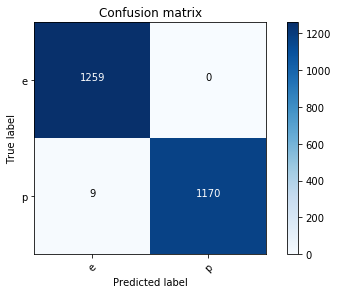

In [52]:
class_names = ['e', 'p']
plot_confusion_matrix(confusion, classes=class_names,
                      title='Confusion matrix')

Try different values for the cost function for errors (the 'C' error term).  Also try different test/train splits to check the robustness of the 'C' term value chosen.  With a high enough 'C', the model becomes 100% accurate.

In [53]:
seeds = (245, 333, 555, 1234, 32487, 67209, 176589)

for seed in seeds:
    print '\nseed=%d' % seed
    # 70/30 split of data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    C = (1.0, 2.5, 5.0, 10.0, 15.0, 20.0, 25.0)

    for c in C:
        clf = SVC(C=c)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)

        print 'SVC Model (C=%.1f): %.2f%% accurate' % (c, (metrics.accuracy_score(y_test, pred) * 100.0))


seed=245
SVC Model (C=1.0): 99.63% accurate
SVC Model (C=2.5): 99.96% accurate
SVC Model (C=5.0): 100.00% accurate
SVC Model (C=10.0): 100.00% accurate
SVC Model (C=15.0): 100.00% accurate
SVC Model (C=20.0): 100.00% accurate
SVC Model (C=25.0): 100.00% accurate

seed=333
SVC Model (C=1.0): 99.67% accurate
SVC Model (C=2.5): 99.88% accurate
SVC Model (C=5.0): 99.96% accurate
SVC Model (C=10.0): 100.00% accurate
SVC Model (C=15.0): 100.00% accurate
SVC Model (C=20.0): 100.00% accurate
SVC Model (C=25.0): 100.00% accurate

seed=555
SVC Model (C=1.0): 99.67% accurate
SVC Model (C=2.5): 99.96% accurate
SVC Model (C=5.0): 100.00% accurate
SVC Model (C=10.0): 100.00% accurate
SVC Model (C=15.0): 100.00% accurate
SVC Model (C=20.0): 100.00% accurate
SVC Model (C=25.0): 100.00% accurate

seed=1234
SVC Model (C=1.0): 99.51% accurate
SVC Model (C=2.5): 99.84% accurate
SVC Model (C=5.0): 99.84% accurate
SVC Model (C=10.0): 100.00% accurate
SVC Model (C=15.0): 100.00% accurate
SVC Model (C=20.0):

It appears that increasing 'C' to 10 or more makes the model 100% accurate.  This is a good result when dealing with a safety issue such as edible or poisonous mushrooms.  Since there appears to be no problem in this case with increasing the value for the 'C' cost parameter perhaps a little safety margin is good and using a value such as 15 or 20 would be best.  Other SVC parameters could also be investigated, but since the model already shows 100% accuracy this seems unnecessary here.

Citation: Mushroom Data Set (1987). UCI Machine Learning Repository. Retrieved from: https://archive.ics.uci.edu/ml/datasets/mushroom. 